## データ準備

In [ ]:
import urllib.request
import sys

#ダウンロード
url = "https://www.rondhuit.com/download/ldcc-20140209.tar.gz"
urllib.request.urlretrieve(url,"ldcc-20140209.tar.gz")
# 解凍
!tar xvf ldcc-20140209.tar.gz

In [2]:
import pandas as pd
import os
from glob import glob
import linecache

# カテゴリを配列で取得
categories = [name for name in os.listdir('text') if os.path.isdir(f'text/{name}')]
print('カテゴリ：', categories)
print('カテゴリ数：', len(categories))

title_list = []
body_list = []
cat_list = []
for category in categories:
  path = f'text/{category}/*.txt'
  files = glob(path)
  for text_name in files:
    # 各テキストの3行目をリストに追加（タイトル）
    title_list.append(linecache.getline(text_name, 3))
    # 各テキストの4〜10行目をリストに追加（本文）
    body = ''
    for body_line in range(4, 10):
      body += linecache.getline(text_name, body_line)
    body_list.append(body)
    # 各テキストのカテゴリーをリストに追加
    cat_list.append(category)

cols = {'TITLE': title_list, 'BODY': body_list, 'CATEGORY': cat_list}
df = pd.DataFrame(cols)
df.head()

カテゴリ： ['kaden-channel', 'topic-news', 'peachy', 'movie-enter', 'livedoor-homme', 'smax', 'sports-watch', 'it-life-hack', 'dokujo-tsushin']
カテゴリ数： 9


,TITLE,BODY,CATEGORY
0,iPhoneだけじゃない！！ サムスンの「GALAXY S II」もいきなり発火【話題】\n,先日、オーストラリアでiPhoneが突然白い煙をあげたというニュースがあったが、サムスンの「...,kaden-channel
1,コンパスを使うのは年に１度？ iPhoneで一番不要な機能とは【話題】\n,多くの機能があり便利なのがiPhoneだが、いらないと思った機能のひとつやふたつあるのではな...,kaden-channel
2,感想をシェアしながら映画鑑賞！ ニコニコ動画がワーナーと連携し映画配信【話題】\n,動画に書き込んだコメントが流れることが特徴のニコニコ動画。ここに新しいコンテンツが登場した。...,kaden-channel
3,過去３００年の新聞をすべてアーカイブ！ 大英国図書館が有料サービスを開始【話題】\n,イギリスの由緒ある図書館、大英国図書館が18世紀前半以降の新聞記事アーカイブを公開する有償サ...,kaden-channel
4,視聴率が悪いのはネットのせい？ テレビ関係者のコメントにネットが反論【話題】\n,俳優オダギリジョー主演のドラマ「家族のうた」（フジテレビ）の第３話の視聴率が発表された。数字...,kaden-channel


## データを眺める

In [3]:
len(df)

7376

In [4]:
df['CATEGORY'].value_counts()

sports-watch      901
it-life-hack      871
movie-enter       871
smax              871
dokujo-tsushin    871
kaden-channel     865
peachy            843
topic-news        771
livedoor-homme    512
Name: CATEGORY, dtype: int64

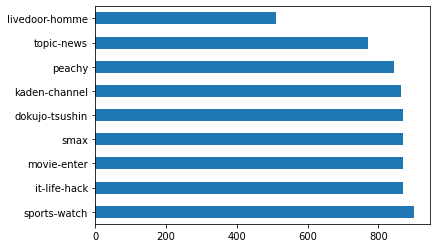

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

df['CATEGORY'].value_counts().plot(kind='barh')

In [ ]:
df['CATEGORY'].value_counts().plot.kde()

## 前処理

In [6]:
import re

def preprocessing(text):
  # 全角 => 半角
  text = text.translate(str.maketrans({chr(0xFF01 + i): chr(0x21 + i) for i in range(94)}))
  # 英語大文字を小文字化
  text = text.lower()
  # 削除する文字列
  remove_list = ['\n', '　', ' ']
  for rem_word in remove_list:
    text = text.replace(rem_word, '')
  # 数字列を0に置換
  text = re.sub('[0-9]+', '0', text)

  return text

In [7]:
df['TITLE'] = df['TITLE'].map(preprocessing)

In [8]:
df['BODY'] = df['BODY'].map(preprocessing)

In [9]:
df.head()

,TITLE,BODY,CATEGORY
0,iphoneだけじゃない!!サムスンの「galaxysii」もいきなり発火【話題】,先日、オーストラリアでiphoneが突然白い煙をあげたというニュースがあったが、サムスンの「...,kaden-channel
1,コンパスを使うのは年に0度?iphoneで一番不要な機能とは【話題】,多くの機能があり便利なのがiphoneだが、いらないと思った機能のひとつやふたつあるのではな...,kaden-channel
2,感想をシェアしながら映画鑑賞!ニコニコ動画がワーナーと連携し映画配信【話題】,動画に書き込んだコメントが流れることが特徴のニコニコ動画。ここに新しいコンテンツが登場した。...,kaden-channel
3,過去0年の新聞をすべてアーカイブ!大英国図書館が有料サービスを開始【話題】,イギリスの由緒ある図書館、大英国図書館が0世紀前半以降の新聞記事アーカイブを公開する有償サイ...,kaden-channel
4,視聴率が悪いのはネットのせい?テレビ関係者のコメントにネットが反論【話題】,俳優オダギリジョー主演のドラマ「家族のうた」(フジテレビ)の第0話の視聴率が発表された。数字...,kaden-channel


## Mecabインストール

In [ ]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n

!sed -e "s!/var/lib/mecab/dic/debian!/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd!g" /etc/mecabrc &gt; /etc/mecabrc.new
!cp /etc/mecabrc /etc/mecabrc.org
!cp /etc/mecabrc.new /etc/mecabrc

## 分かち書き

In [11]:
import MeCab

def tokenize(text, target_pos=['名詞', '形容詞', '形容動詞', '動詞', '副詞']):
  tokens = []
  mecab = MeCab.Tagger ('-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd')
  mecab.parse('') #文字列がGCされるのを防ぐ
  node = mecab.parseToNode(text)
  while node:
    #単語を取得
    word = node.surface
    #品詞を取得
    pos = node.feature.split(",")[0]
    # 名詞の場合のみ抽出
    if pos in target_pos:
      tokens.append(word)
    #次の単語に進める
    node = node.next
  return tokens

In [12]:
df['TITLE_WAKATI'] = df['TITLE'].map(lambda x: ' '.join(tokenize(x)))
df['BODY_WAKATI'] = df['BODY'].map(lambda x: ' '.join(tokenize(x)))
df.head()

,TITLE,BODY,CATEGORY,TITLE_WAKATI,BODY_WAKATI
0,iphoneだけじゃない!!サムスンの「galaxysii」もいきなり発火【話題】,先日、オーストラリアでiphoneが突然白い煙をあげたというニュースがあったが、サムスンの「...,kaden-channel,iphone サムスン galaxy sii いきなり 発火 話題,先日 オーストラリア iphone 突然 白い 煙 あげ ニュース あっ サムスン gala...
1,コンパスを使うのは年に0度?iphoneで一番不要な機能とは【話題】,多くの機能があり便利なのがiphoneだが、いらないと思った機能のひとつやふたつあるのではな...,kaden-channel,コンパス 使う の 年 0度 iphone 一番 不要 機能 話題,多く 機能 あり 便利 の iphone いら 思っ 機能 ひとつ ふたつ ある の ネット...
2,感想をシェアしながら映画鑑賞!ニコニコ動画がワーナーと連携し映画配信【話題】,動画に書き込んだコメントが流れることが特徴のニコニコ動画。ここに新しいコンテンツが登場した。...,kaden-channel,感想 シェア しながら 映画鑑賞 ニコニコ動画 ワーナー 連携 し 映画 配信 話題,動画 書き込ん コメント 流れる こと 特徴 ニコニコ動画 ここに 新しい コンテンツ 登場...
3,過去0年の新聞をすべてアーカイブ!大英国図書館が有料サービスを開始【話題】,イギリスの由緒ある図書館、大英国図書館が0世紀前半以降の新聞記事アーカイブを公開する有償サイ...,kaden-channel,過去 0 年 新聞 すべて アーカイブ 英国 図書館 有料 サービス 開始 話題,イギリス 由緒 ある 図書館 英国 図書館 0 世紀 前半 以降 新聞記事 アーカイブ 公開...
4,視聴率が悪いのはネットのせい?テレビ関係者のコメントにネットが反論【話題】,俳優オダギリジョー主演のドラマ「家族のうた」(フジテレビ)の第0話の視聴率が発表された。数字...,kaden-channel,視聴率 悪い の ネット せい テレビ 関係 者 コメント ネット 反論 話題,俳優 オダギリジョー 主演 ドラマ 家族のうた フジテレビ 0 話 視聴率 発表 さ れ 数...


## 目的変数をIDに変換

In [13]:
ctgs_dict = {}
for idx, ctg in enumerate(categories):
  ctgs_dict[ctg] = idx

df['CATEGORY_CODE'] = df['CATEGORY'].map(ctgs_dict)
df[::777]

,TITLE,BODY,CATEGORY,TITLE_WAKATI,BODY_WAKATI,CATEGORY_CODE
0,iphoneだけじゃない!!サムスンの「galaxysii」もいきなり発火【話題】,先日、オーストラリアでiphoneが突然白い煙をあげたというニュースがあったが、サムスンの「...,kaden-channel,iphone サムスン galaxy sii いきなり 発火 話題,先日 オーストラリア iphone 突然 白い 煙 あげ ニュース あっ サムスン gala...,0
777,「老後どうすんの?」さんまの質問にメッシが激怒!テレビが凍りついた瞬間【話題】,「toyotaプレゼンツfifaクラブワールドカップジャパン0」の決勝戦が0日、横浜国際総合...,kaden-channel,老後 どう すん さんま 質問 メッシ 激怒 テレビ 凍りつい 瞬間 話題,toyota プレゼンツ fifaクラブワールドカップ ジャパン 0 決勝戦 0 日 横浜国...,0
1554,少女時代の作曲家が人種差別的発言…少女時代にも批判が飛び火,少女時代の作曲家であるジェニー・ヒュンが人種差別的発言をしたと各メディアが伝えており、ネット...,topic-news,少女時代 作曲家 人種差別 的 発言 少女時代 批判 飛び火,少女時代 作曲家 ジェニー・ヒュン 人種差別 的 発言 し メディア 伝え おり ネット上 ...,1
2331,冬の女子会は特製「薬膳火鍋」に決定!美味しく食べてポッカポカ,本格的な寒さを感じるこの季節。「何が食べたい?」と聞かれたら、真っ先に思い浮かぶのはお鍋!ダ...,peachy,冬 女子会 特製 薬膳 火鍋 決定 美味しく 食べ ポッカポカ,本格 的 寒さ 感じる 季節 何 食べ 聞か れ 真っ先 思い 浮かぶ の お鍋 ダシ 効い...,2
3108,0万部突破「図書館戦争」シリーズが映画化、主題歌はbaseballbear「初恋」,「県庁おもてなし課」「フリーター、家を買う。」など、数々のベストセラーを送り出している有川浩...,movie-enter,0 万 部 突破 図書館戦争 シリーズ 映画化 主題歌 baseballbear 初恋,県庁おもてなし課 フリーター、家を買う。 数々 ベストセラー 送り出し いる 有川浩 ありか...,3
3885,こんなアプリもあったのか!スマートフォンがマウスになる、あると便利な「advancedtou...,スマートフォンのタッチパネルでパソコンを操作!youtubeをパソコンのフルスクリーンで楽し...,smax,アプリ あっ の スマートフォン マウス なる ある 便利 advancedtouchpad...,スマートフォン タッチパネル パソコン 操作 youtube パソコン フルスクリーン 楽し...,5
4662,kddi、au向けwimax対応android0.0ics搭載「urbanoprogress...,urbanoシリーズ初のスマートフォン!kddiおよび沖縄セルラーは0日、この夏に発売する予...,smax,kddi au 向け wimax 対応 and roi d0 0 ics 搭載 urbano...,urbanoシリーズ 初 スマートフォン kddi および 沖縄セルラー 0 日 夏 発売 ...,5
5439,【sportswatch】海老蔵殴打事件、元祖夜遊びjリーガーも“絡まれることはある”,歌舞伎俳優、市川海老蔵殴打事件で、傷害の疑いで逮捕された伊藤リオン容疑者。サッカーでは、jリ...,sports-watch,sports watch 海老蔵 殴打 事件 元祖 夜遊び jリーガー 絡ま れる こと ある,歌舞伎俳優 市川海老蔵 殴打 事件 傷害 疑い 逮捕 さ れ 伊藤リオン 容疑者 サッカー ...,6
6216,アナタはまだブラウザのブックマーク?ブックマーク管理はライフリストがオススメ,最近ネットサーフィンをする際にもっぱら利用しているのが「ライフリスト」というサイトだ。この「...,it-life-hack,アナタ まだ ブラウザ ブックマーク ブックマーク 管理 ライフ リスト オススメ,最近 ネットサーフィン する 際 もっぱら 利用 し いる の ライフ リスト サイト ライ...,7
6993,となりの会社のおやつ事情,デザイン会社に勤務するマスミさん(0歳)の楽しみは、0ヶ月に0回の「社内おやつ」の買い出し。...,dokujo-tsushin,となり 会社 おやつ 事情,デザイン会社 勤務 する マスミ さん 0歳 楽しみ 0 ヶ月 0回 社内 おやつ 買い出し...,8


## 学習・検証・評価データに分割

In [14]:
from sklearn.model_selection import train_test_split

train, valid_test = train_test_split(df, test_size=0.2, random_state=144, stratify=df['CATEGORY_CODE'])
valid, test = train_test_split(valid_test, test_size=0.5, random_state=144, stratify=valid_test['CATEGORY_CODE'])

# 事例数の確認
print('===学習データ===')
print(train['CATEGORY_CODE'].value_counts())
print('===検証データ===')
print(valid['CATEGORY_CODE'].value_counts())
print('===評価データ===')
print(test['CATEGORY_CODE'].value_counts())

===学習データ===
6    720
7    697
3    697
5    697
8    697
0    692
2    674
1    617
4    409
Name: CATEGORY_CODE, dtype: int64
===検証データ===
6    90
8    87
7    87
5    87
3    87
0    86
2    85
1    77
4    52
Name: CATEGORY_CODE, dtype: int64
===評価データ===
6    91
8    87
7    87
5    87
3    87
0    87
2    84
1    77
4    51
Name: CATEGORY_CODE, dtype: int64


## Word2Vecによる単語埋め込み

In [15]:
wakati = train[['BODY_WAKATI']]
wakati.to_csv('wakati.csv', sep='\n', header=True, index=False)
wakati

,BODY_WAKATI
4921,0 日 0 連敗 中 現在 0 位 低迷 し いる 阪神タイガース 中でも 打率 0 割 き...
6263,通常 excel 列 表示 a b c よう なっ いる 人 パソコン 使う とき 特定 フ...
6273,以前 筆者 記事 予想 し よう アップル wwdc 0 合わせ 発表 し 新しい macb...
6209,いま クラウド 型 ストレージ サービス デファクトスタンダード 言う サービス 言える 普...
1376,0 日 一部メディア フジテレビ 情報番組 知りたがり! 金曜 レギュラー 出演 する こと...
...,...
394,0 月 android版 先行 登場 し livedoorニュース 無料 公式 アプリ 三面...
5323,0 日 茨城ゴルフ倶楽部 開幕 する ワールド レディス サロンパスカップ 宮里藍 有村智恵...
3968,ゼロ 始める スマートフォン ジャストシステム 0 日 android 向け 文字入力 シス...
2016,昔ながらの 懐かしい 商店街 賑わい みせる 千歳烏山 地元 人々 愛さ れる 街 雰囲気 ...


In [ ]:
from gensim.models import word2vec
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
sentence_data = word2vec.LineSentence('wakati.csv')
vectorizer = word2vec.Word2Vec(sentence_data,
                         sg=1,        # Skip-gram
                         size=300,    # 次元数
                         min_count=5, # min_count回未満の単語を破棄
                         window=3,    # 文脈の最大単語数
                         hs=0,        # 階層ソフトマックス(ネガティブサンプリングするなら0)
                         negative=5,  # ネガティブサンプリング
                         iter=100      # Epoch数
                         )

In [17]:
vectorizer.most_similar('映画')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2021-06-28 14:29:05,700 : INFO : precomputing L2-norms of word weight vectors


[('指輪をはめたい', 0.41661548614501953),
 ('キャプテン・アメリカ/ザ・ファースト・アベンジャー', 0.4006258547306061),
 ('完成披露試写会', 0.39491355419158936),
 ('フライトナイト/恐怖の夜', 0.3894181251525879),
 ('themovie', 0.38604772090911865),
 ('グラディエーター', 0.38051730394363403),
 ('カンタ', 0.3731711506843567),
 ('新作映画', 0.3722120225429535),
 ('全国公開', 0.36964526772499084),
 ('新劇場版', 0.3658650517463684)]

In [ ]:
# メソッド一覧
import inspect
for x in inspect.getmembers(vectorizer, inspect.ismethod):
  print(x[0])

## 学習済みWord2Vec（ChiVe）による単語埋め込み

In [37]:
import gensim
import urllib.request
import sys

#ダウンロード
url = "https://sudachi.s3-ap-northeast-1.amazonaws.com/chive/chive-1.2-mc90_gensim.tar.gz"  #ファイルのURLを指定
urllib.request.urlretrieve(url,"chive.tar.gz")
#解凍
!tar -zxvf chive.tar.gz

vectorizer = gensim.models.KeyedVectors.load("chive-1.2-mc90_gensim/chive-1.2-mc90.kv")

chive-1.2-mc90_gensim/
chive-1.2-mc90_gensim/LICENSE
chive-1.2-mc90_gensim/README.md
chive-1.2-mc90_gensim/chive-1.2-mc90.kv.vectors.npy
chive-1.2-mc90_gensim/chive-1.2-mc90.kv


2021-06-28 05:33:43,878 : INFO : loading Word2VecKeyedVectors object from chive-1.2-mc90_gensim/chive-1.2-mc90.kv
2021-06-28 05:33:45,992 : INFO : loading vectors from chive-1.2-mc90_gensim/chive-1.2-mc90.kv.vectors.npy with mmap=None
2021-06-28 05:33:48,292 : INFO : setting ignored attribute vectors_norm to None
2021-06-28 05:33:48,294 : INFO : loaded chive-1.2-mc90_gensim/chive-1.2-mc90.kv


In [38]:
vectorizer.most_similar('映画')

2021-06-28 05:34:07,993 : INFO : precomputing L2-norms of word weight vectors


[('邦画', 0.7711033821105957),
 ('予告編', 0.7660966515541077),
 ('主演', 0.7257440090179443),
 ('ハリウッド', 0.7001019716262817),
 ('映画館', 0.6935902237892151),
 ('映画界', 0.689943253993988),
 ('劇映画', 0.6886698007583618),
 ('話題作', 0.684718132019043),
 ('映画化', 0.681873083114624),
 ('上映', 0.6801760196685791)]

## TF-IDFによる単語埋め込み

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 2))

In [65]:
# 特徴ベクトルの作成
X_train = vectorizer.fit_transform(train['BODY_WAKATI'])
X_valid = vectorizer.transform(valid['BODY_WAKATI'])
X_test = vectorizer.transform(test['BODY_WAKATI'])

print(X_train.shape)

(5900, 376849)


## 単語埋め込みから特徴ベクトル作成

In [18]:
import string
import torch
import numpy as np

def transform_w2v(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  words = text.translate(table).split()  # 記号をスペースに置換後、スペースで分割してリスト化
  vec = [vectorizer[word] for word in words if word in vectorizer]  # 1語ずつベクトル化

  if len(vec) != 0:
    return torch.tensor(sum(vec) / len(vec))
  else:
    return torch.tensor(np.zeros(300))

In [19]:
# 特徴ベクトルの作成
X_train = torch.stack([transform_w2v(text) for text in train['BODY_WAKATI']])
X_valid = torch.stack([transform_w2v(text) for text in valid['BODY_WAKATI']])
X_test = torch.stack([transform_w2v(text) for text in test['BODY_WAKATI']])

print(X_train.size())
print(X_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


torch.Size([5900, 300])
tensor([[ 0.0844,  0.0349,  0.0153,  ..., -0.0372, -0.0199,  0.1348],
        [ 0.1903, -0.1339, -0.1134,  ...,  0.1252, -0.0053,  0.1227],
        [ 0.1564, -0.1329, -0.1911,  ...,  0.0554,  0.0260,  0.1537],
        ...,
        [-0.0384, -0.1945, -0.2214,  ...,  0.0775,  0.0442,  0.1336],
        [ 0.0520, -0.0418,  0.1076,  ...,  0.0302, -0.0546,  0.2851],
        [-0.0090, -0.1007, -0.0882,  ..., -0.0492,  0.0349,  0.1201]])


## ラベルベクトルの作成

In [20]:
y_train = torch.tensor(train['CATEGORY_CODE'].values)
y_valid = torch.tensor(valid['CATEGORY_CODE'].values)
y_test = torch.tensor(test['CATEGORY_CODE'].values)

print(y_train.size())
print(y_train)

torch.Size([5900])
tensor([6, 7, 7,  ..., 5, 2, 1])


## 学習 => 予測 => 精度評価

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def learn_pred_accuracy(clf, train_x, train_y, valid_x, valid_y, test_x, test_y):
  # 学習
  clf.fit(train_x, train_y)
  # 予測
  predict_vy = clf.predict(valid_x)
  predict_y = clf.predict(test_x)
  # 正解率
  print('検証True:', np.count_nonzero(predict_vy == valid_y))
  print('検証False:', np.count_nonzero(predict_vy != valid_y))
  print('検証正解率:', np.count_nonzero(predict_vy == valid_y) / len(valid_y))
  print('テストTrue:', np.count_nonzero(predict_y == test_y))
  print('テストFalse:', np.count_nonzero(predict_y != test_y))
  print('テスト正解率:', np.count_nonzero(predict_y == test_y) / len(test_y))
  # 様々な精度結果
  print(classification_report(test_y, predict_y))
  # 正解と予測データ
  print('検証正解：', valid_y[:20])
  print('検証予測：', predict_vy[:20])
  print('test正解：', test_y[:20])
  print('test予測：', predict_y[:20])
  # DF化
  ## valid
  pred_df = pd.DataFrame({'data': predict_vy, 'type': 'pred'})
  true_df = pd.DataFrame({'data': valid_y, 'type': 'true'})
  valid_df = pd.concat([true_df, pred_df]).reset_index(drop=True)
  ## test
  pred_df = pd.DataFrame({'data': predict_y, 'type': 'pred'})
  true_df = pd.DataFrame({'data': test_y, 'type': 'true'})
  test_df = pd.concat([true_df, pred_df]).reset_index(drop=True)
  # 予測データのヒストグラム
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
  sns.countplot(data=valid_df, x='data', hue='type', ax=ax1)
  sns.countplot(data=test_df, x='data', hue='type', ax=ax2)
  # 混合行列
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
  cm = confusion_matrix(valid_y, predict_vy)
  p1 = sns.heatmap(cm, cmap='jet', annot=True, ax=ax1)
  p1.set(xlabel='predict', ylabel='true')
  cm = confusion_matrix(test_y, predict_y)
  p2 = sns.heatmap(cm, cmap='jet', annot=True, ax=ax2)
  p2.set(xlabel='predict', ylabel='true')

## Naive Bayes

検証True: 497
検証False: 241
検証正解率: 0.6734417344173442
テストTrue: 540
テストFalse: 198
テスト正解率: 0.7317073170731707
              precision    recall  f1-score   support

           0       0.57      0.67      0.62        87
           1       0.77      0.86      0.81        77
           2       0.73      0.71      0.72        84
           3       0.84      0.91      0.87        87
           4       1.00      0.14      0.24        51
           5       0.79      0.72      0.75        87
           6       0.91      0.87      0.89        91
           7       0.65      0.61      0.63        87
           8       0.63      0.86      0.73        87

    accuracy                           0.73       738
   macro avg       0.77      0.71      0.70       738
weighted avg       0.75      0.73      0.72       738

検証正解： [0 3 4 7 3 6 3 0 7 2 6 2 6 4 8 1 5 6 7 7]
検証予測： [6 3 2 3 3 6 3 0 7 7 6 2 6 0 8 7 0 0 7 7]
test正解： [4 7 6 6 1 0 6 3 7 1 3 8 0 0 2 8 4 3 5 6]
test予測： [3 7 6 6 1 0 6 3 7 1 3 8 0 0 2 8 7 3

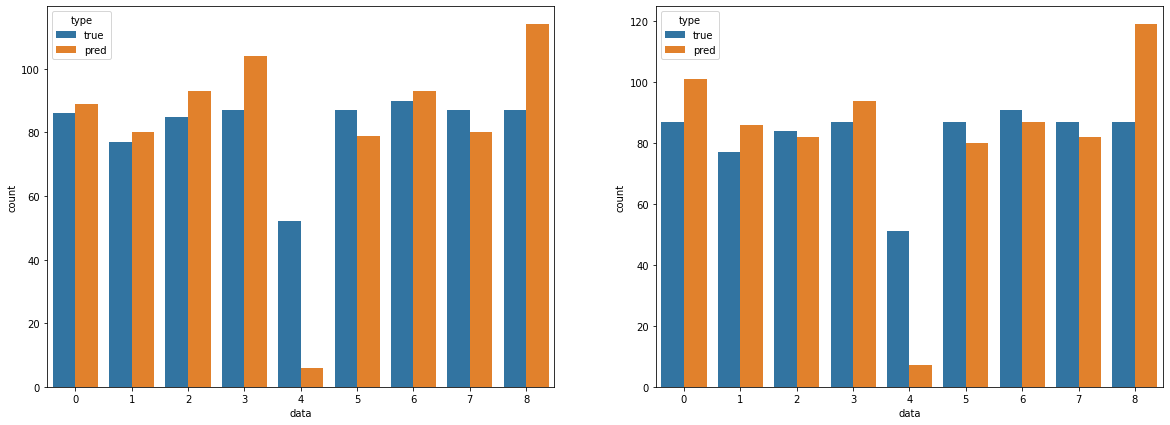

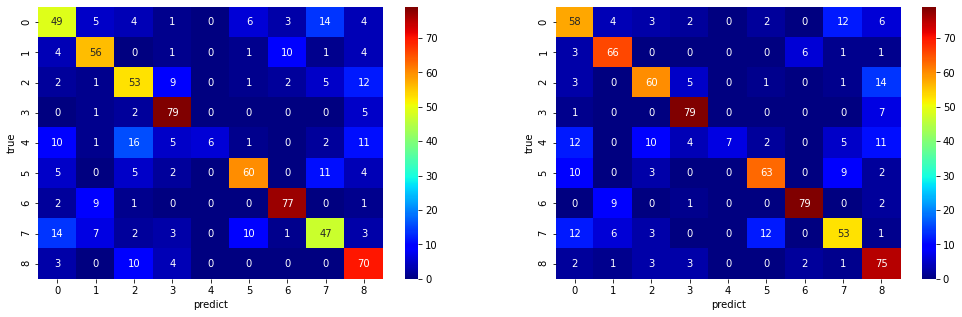

In [22]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn import preprocessing

clf = MultinomialNB(alpha=.01)
mm = preprocessing.MinMaxScaler()
try:
  X_train_mm = mm.fit_transform(X_train)
except:
  X_train_mm = X_train
try:
  X_valid_mm = mm.transform(X_valid)
except:
  X_valid_mm = X_valid
try:
  X_test_mm = mm.transform(X_test)
except:
  X_test_mm = X_test
learn_pred_accuracy(clf, X_train_mm, y_train, X_valid_mm, np.array(y_valid), X_test_mm, np.array(y_test))

## Decision Tree Classifier

検証True: 381
検証False: 357
検証正解率: 0.516260162601626
テストTrue: 405
テストFalse: 333
テスト正解率: 0.5487804878048781
              precision    recall  f1-score   support

           0       0.34      0.38      0.36        87
           1       0.61      0.62      0.62        77
           2       0.48      0.51      0.50        84
           3       0.63      0.60      0.62        87
           4       0.29      0.33      0.31        51
           5       0.74      0.66      0.70        87
           6       0.75      0.67      0.71        91
           7       0.52      0.49      0.51        87
           8       0.55      0.59      0.57        87

    accuracy                           0.55       738
   macro avg       0.55      0.54      0.54       738
weighted avg       0.56      0.55      0.55       738

検証正解： [0 3 4 7 3 6 3 0 7 2 6 2 6 4 8 1 5 6 7 7]
検証予測： [0 3 0 5 0 6 5 2 7 5 6 0 6 4 0 7 1 6 2 1]
test正解： [4 7 6 6 1 0 6 3 7 1 3 8 0 0 2 8 4 3 5 6]
test予測： [3 0 6 6 1 5 1 8 7 1 3 2 3 8 0 8 7 3 

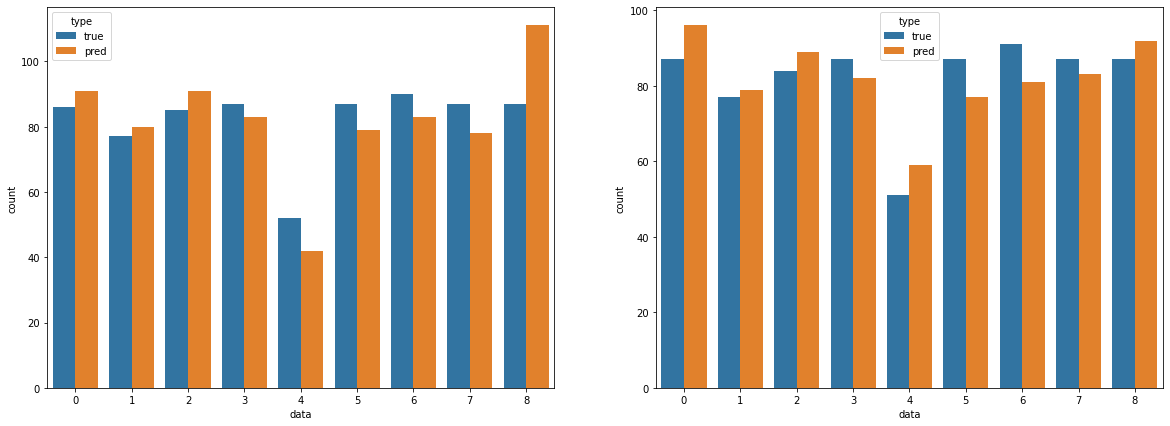

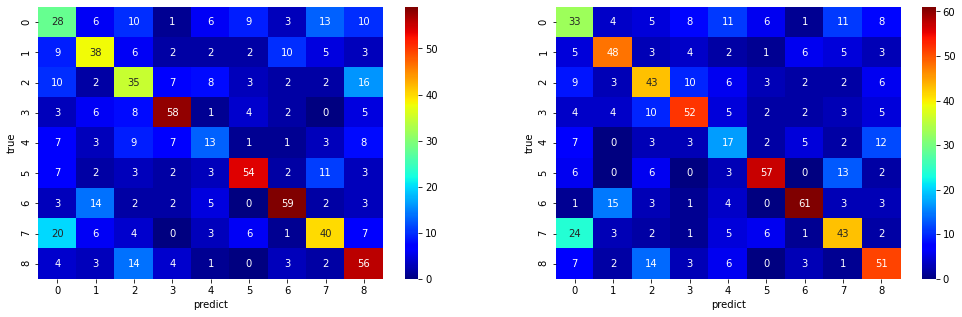

In [23]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=144)
learn_pred_accuracy(clf, X_train, y_train, X_valid, np.array(y_valid), X_test, np.array(y_test))

## XGBoost

検証True: 543
検証False: 195
検証正解率: 0.7357723577235772
テストTrue: 586
テストFalse: 152
テスト正解率: 0.7940379403794038
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        87
           1       0.82      0.87      0.84        77
           2       0.72      0.80      0.76        84
           3       0.88      0.93      0.91        87
           4       0.77      0.39      0.52        51
           5       0.94      0.78      0.86        87
           6       0.94      0.89      0.92        91
           7       0.68      0.75      0.71        87
           8       0.79      0.87      0.83        87

    accuracy                           0.79       738
   macro avg       0.80      0.78      0.78       738
weighted avg       0.80      0.79      0.79       738

検証正解： [0 3 4 7 3 6 3 0 7 2 6 2 6 4 8 1 5 6 7 7]
検証予測： [1 3 4 4 3 6 3 4 7 5 6 0 6 4 2 7 0 0 7 7]
test正解： [4 7 6 6 1 0 6 3 7 1 3 8 0 0 2 8 4 3 5 6]
test予測： [4 7 6 6 1 0 6 3 7 1 3 8 4 0 2 8 7 3

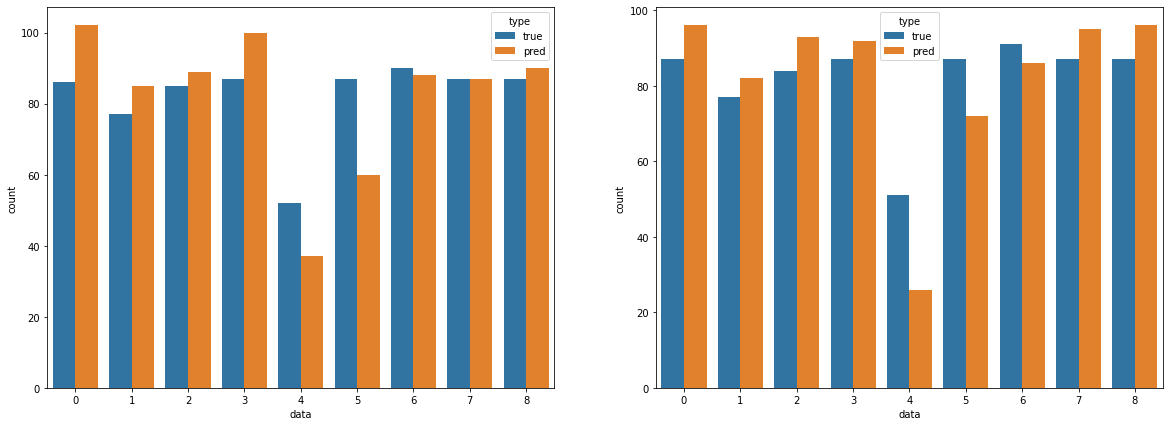

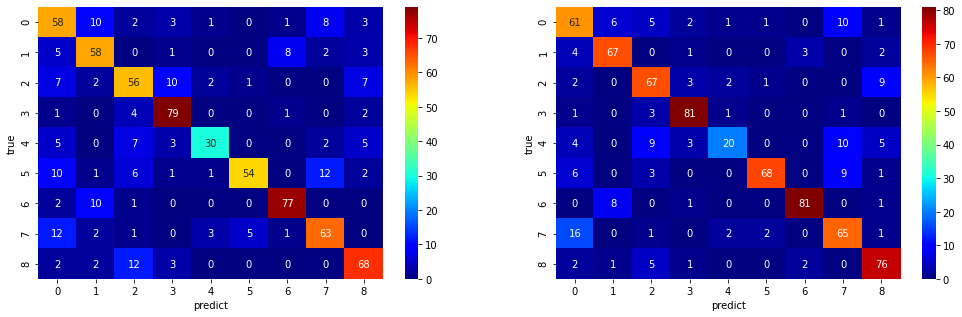

In [24]:
from xgboost import XGBClassifier

clf = XGBClassifier(random_state=144, objective='binary:logistic')
learn_pred_accuracy(clf, X_train, y_train, X_valid, np.array(y_valid), X_test, np.array(y_test))

## ロジスティック回帰

検証True: 592
検証False: 146
検証正解率: 0.8021680216802168
テストTrue: 624
テストFalse: 114
テスト正解率: 0.8455284552845529
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        87
           1       0.88      0.92      0.90        77
           2       0.85      0.86      0.85        84
           3       0.89      0.99      0.93        87
           4       0.83      0.47      0.60        51
           5       0.95      0.80      0.87        87
           6       0.95      0.91      0.93        91
           7       0.78      0.85      0.81        87
           8       0.78      0.86      0.82        87

    accuracy                           0.85       738
   macro avg       0.85      0.83      0.83       738
weighted avg       0.85      0.85      0.84       738

検証正解： [0 3 4 7 3 6 3 0 7 2 6 2 6 4 8 1 5 6 7 7]
検証予測： [0 3 4 7 3 6 3 2 7 5 6 8 6 4 2 7 5 4 7 7]
test正解： [4 7 6 6 1 0 6 3 7 1 3 8 0 0 2 8 4 3 5 6]
test予測： [3 7 6 6 1 0 6 3 7 1 3 8 4 0 2 8 7 3

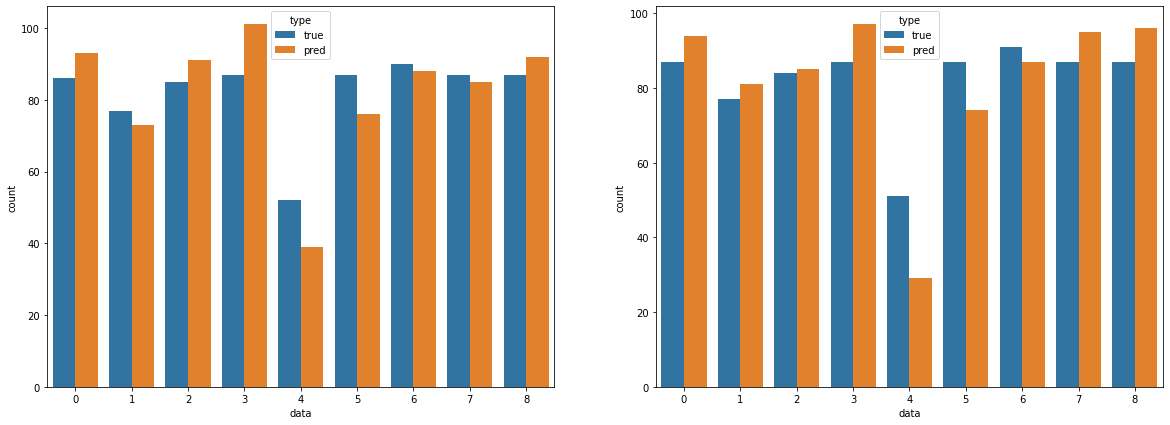

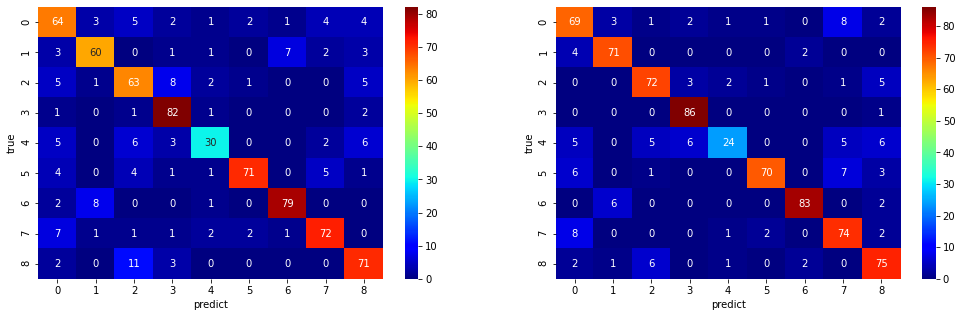

In [25]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=144, max_iter=144000)
learn_pred_accuracy(clf, X_train, y_train, X_valid, np.array(y_valid), X_test, np.array(y_test))

## LSTM

In [ ]:
# バッチサイズを1とする
"""
X_train = X_train.view(len(X_train), 1, -1)
X_valid = X_valid.view(len(X_valid), 1, -1)
X_test = X_test.view(len(X_test), 1, -1)

print('X_train:', X_train.size())
print('X_valid:', X_valid.size())
print('X_test:', X_test.size())
"""

In [26]:
import torch
import torch.nn as nn

# nn.Moduleを継承して新しいクラスを作る。決まり文句
class LSTMClassifier(nn.Module):
  # モデルで使う各ネットワークをコンストラクタで定義
  def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
    # 親クラスのコンストラクタ。決まり文句
    super(LSTMClassifier, self).__init__()
    # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。
    self.hidden_dim = hidden_dim
    # インプットの単語をベクトル化するために使う
    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
    # LSTMの隠れ層。これ１つでOK。超便利。
    self.lstm = nn.LSTM(embedding_dim, hidden_dim)
    # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
    self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
    # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
    self.softmax = nn.LogSoftmax(dim=1)

  # 順伝播処理はforward関数に記載
  def forward(self, sentence):
    # 文章内の各単語をベクトル化して出力。2次元のテンソル
    embeds = self.word_embeddings(sentence)
    # 2次元テンソルをLSTMに食わせられる様にviewで３次元テンソルにした上でLSTMへ流す。
    # 上記で説明した様にmany to oneのタスクを解きたいので、第二戻り値だけ使う。
    _, lstm_out = self.lstm(embeds.view(len(sentence), 1, -1))
    # lstm_out[0]は３次元テンソルになってしまっているので2次元に調整して全結合。
    tag_space = self.hidden2tag(lstm_out[0].view(-1, self.hidden_dim))
    # softmaxに食わせて、確率として表現
    tag_scores = self.softmax(tag_space)
    return tag_scores

In [27]:
import torch.optim as optim

# 単語ID辞書を作成する
word2index = {}
for body in df['BODY']:
  wakati = tokenize(body)
  for word in wakati:
    if word in word2index: continue
    word2index[word] = len(word2index)

# trainとtestに分割
traindata, testdata = train_test_split(df, train_size=0.8)
# 単語のベクトル次元数
EMBEDDING_DIM = 10
# 隠れ層の次元数
HIDDEN_DIM = 128
# データ全体の単語数
VOCAB_SIZE = len(word2index)
# 分類先のカテゴリの数
TAG_SIZE = len(categories)
# モデル宣言
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAG_SIZE)
# 損失関数はNLLLoss()を使う。LogSoftmaxを使う時はこれを使うらしい。
loss_function = nn.NLLLoss()
# 最適化の手法はSGDで。lossの減りに時間かかるけど、一旦はこれを使う。
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 文章を単語IDの系列データに変換
# PyTorchのLSTMのインプットになるデータなので、もちろんtensor型で
def sentence2index(sentence):
  wakati = tokenize(sentence)
  return torch.tensor([word2index.get(w, 0) for w in wakati], dtype=torch.long)

category2index = {}
for cat in categories:
  if cat in category2index: continue
  category2index[cat] = len(category2index)

def category2tensor(cat):
  return torch.tensor([category2index[cat]], dtype=torch.long)

# 各エポックの合計loss値を格納する
losses = []
# 10ループ回してみる。（バッチ化とかGPU使ってないので結構時間かかる...）
for epoch in range(100):
    all_loss = 0
    for title, cat in zip(traindata['TITLE'], traindata['CATEGORY']):
        # モデルが持ってる勾配の情報をリセット
        model.zero_grad()
        # 文章を単語IDの系列に変換（modelに食わせられる形に変換）
        inputs = sentence2index(title)
        # 順伝播の結果を受け取る
        out = model(inputs)
        # 正解カテゴリをテンソル化
        answer = category2tensor(cat)
        # 正解とのlossを計算
        loss = loss_function(out, answer)
        # 勾配をセット
        loss.backward()
        # 逆伝播でパラメータ更新
        optimizer.step()
        # lossを集計
        all_loss += loss.item()
    losses.append(all_loss)
    print('epoch', epoch, '\t' , 'loss', all_loss)
print('done.')

epoch 0 	 loss 12516.618558585644
epoch 1 	 loss 11561.870995014906
epoch 2 	 loss 10432.724759422243
epoch 3 	 loss 8912.164867054671
epoch 4 	 loss 8241.326593821868
epoch 5 	 loss 7874.037762549473
epoch 6 	 loss 7309.018563553924
epoch 7 	 loss 6859.129175600188
epoch 8 	 loss 6437.064698550428
epoch 9 	 loss 6011.973187330848
epoch 10 	 loss 5583.927710120115
epoch 11 	 loss 5161.168123680029
epoch 12 	 loss 4728.224502765361
epoch 13 	 loss 4281.776644387408
epoch 14 	 loss 3813.678574675787
epoch 15 	 loss 3344.541131103965
epoch 16 	 loss 2850.580169299434
epoch 17 	 loss 2369.5561846939054
epoch 18 	 loss 1866.8228438321623
epoch 19 	 loss 1469.542318379309
epoch 20 	 loss 1123.6435470802494
epoch 21 	 loss 828.6741409350677
epoch 22 	 loss 815.8283986132798
epoch 23 	 loss 869.3794706671088
epoch 24 	 loss 508.64012890651713
epoch 25 	 loss 308.15312216688926
epoch 26 	 loss 228.17515916655853
epoch 27 	 loss 164.22050609767516
epoch 28 	 loss 125.11387259420485
epoch 29 	 lo

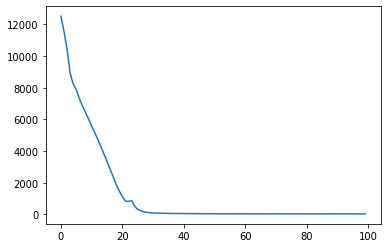

In [28]:
plt.plot(losses)

In [30]:
# テストデータの母数計算
test_num = len(testdata)
# 正解の件数
a = 0
# 勾配自動計算OFF
with torch.no_grad():
    for body, category in zip(testdata['BODY'], testdata['CATEGORY']):
        # テストデータの予測
        inputs = sentence2index(body)
        out = model(inputs)

        # outの一番大きい要素を予測結果をする
        _, predict = torch.max(out, 1)

        answer = category2tensor(category)
        if predict == answer:
            a += 1
print("predict : ", a / test_num)

predict :  0.12669376693766937
